# World Happiness Report 2020

## Data Analysis

In [58]:
import numpy as np
import pandas as pd 
import os

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt                  
import chart_studio.plotly as py  
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import StandardScaler
from impyute.imputation.cs import mice
from sklearn import preprocessing
import statsmodels.api as sm
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

performance_metrics=[['Misclassified Samples','Accuracy','Mean Squared Error','Coeffiecent of Determination']]
def analysis_score(model,ip,op,pred):
    print('Misclassified samples: {0}'.format((op != pred).sum()))    # unrealistic criterion for regression
    print('Misclassified samples on basis of difference greater than standard deviation: {0}'.format((abs(op-pred)>np.std(pred)).sum()))
    print('Test data accuracy: {0:.2f}'.format(model.score(ip, op)))
    print('Mean squared error: %.2f'% mean_squared_error(op, pred))
    print('Coefficient of determination: %.2f'% r2_score(op, pred))
    return (op != pred).sum(),round(model.score(ip, op),2),round(mean_squared_error(op, pred),2),round(r2_score(op, pred),2)

In [2]:
df = pd.read_excel('WHR20.xls')
df.head()

,Country name,Region,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,...,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-2017, unbalanced panel","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014"
0,Afghanistan,Southern Asia,2008,3.723590,7.144916,0.450662,50.799999,0.718114,0.178993,0.881686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,Southern Asia,2009,4.401778,7.314788,0.552308,51.200001,0.678896,0.201228,0.850035,...,NaN,NaN,0.441906,0.286315,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,Southern Asia,2010,4.758381,7.421525,0.539075,51.599998,0.600127,0.131578,0.706766,...,NaN,NaN,0.327318,0.275833,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,Southern Asia,2011,3.831719,7.394349,0.521104,51.919998,0.495901,0.173452,0.731109,...,NaN,NaN,0.336764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,Southern Asia,2012,3.782938,7.480296,0.520637,52.240002,0.530935,0.246943,0.775620,...,NaN,NaN,0.344540,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dealing With Missing Values

In [3]:
df.isnull().sum()

Country name                                                                0
Region                                                                      0
year                                                                        0
Life Ladder                                                                 0
Log GDP per capita                                                         29
Social support                                                             13
Healthy life expectancy at birth                                           52
Freedom to make life choices                                               31
Generosity                                                                 83
Perceptions of corruption                                                 103
Positive affect                                                            21
Negative affect                                                            15
Confidence in national government                               

Dropping columns that are mostly empty and renaming other columns.

In [4]:
df = df.drop(columns=['GINI index (World Bank estimate)',
                      'gini of household income reported in Gallup, by wp5-year',
                      'Most people can be trusted, Gallup', 
                      'Most people can be trusted, WVS round 1981-1984',
                      'Most people can be trusted, WVS round 1989-1993',
                      'Most people can be trusted, WVS round 1994-1998',
                      'Most people can be trusted, WVS round 1999-2004',
                      'Most people can be trusted, WVS round 2005-2009',
                      'Most people can be trusted, WVS round 2010-2014'])

df.rename(columns = {'Country name' : 'Country',
                     'Life Ladder' : 'Happiness_Score',
                           'Log GDP per capita' : 'Economy',
                           'Social support' : 'Social_support',
                           'Freedom to make life choices' : 'Freedom',
                           'Healthy life expectancy at birth' : 'Life_expectancy',
                          'Perceptions of corruption' : 'Trust',
                            'GINI index (World Bank estimate), average 2000-2017, unbalanced panel':'GINI'}, inplace = True)

columns = ['Economy',
       'Social_support', 'Life_expectancy', 'Freedom', 'Generosity', 'Trust',
       'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'GINI']

Filling in the missing data using mean of the values wherever possible and rest of the data using MICE algorithm

In [5]:
# Taking mean of the data to fill the missing values
for column in columns:
    df[column] = df.groupby('Country')[column].transform(lambda grp: grp.fillna(np.mean(grp))) 

#Using MICE algorithm to fill the missing data
finding=np.array(df.values[:,3:],dtype=float)

interpolated = mice(finding)

df['Economy']=df['Economy'].replace(df.values[:,4],interpolated[:,1])
df['Social_support']=df['Social_support'].replace(df.values[:,5],interpolated[:,2])
df['Life_expectancy']=df['Life_expectancy'].replace(df.values[:,6],interpolated[:,3])
df['Generosity']=df['Generosity'].replace(df.values[:,8],interpolated[:,5])
df['Trust']=df['Trust'].replace(df.values[:,9],interpolated[:,6])
df['Positive affect']=df['Positive affect'].replace(df.values[:,10],interpolated[:,7])
df['Negative affect']=df['Negative affect'].replace(df.values[:,11],interpolated[:,8])
df['Confidence in national government']=df['Confidence in national government'].replace(df.values[:,12],interpolated[:,9])
df['Democratic Quality']=df['Democratic Quality'].replace(df.values[:,13],interpolated[:,10])
df['Delivery Quality']=df['Delivery Quality'].replace(df.values[:,14],interpolated[:,11])
df['GINI']=df['GINI'].replace(df.values[:,17],interpolated[:,14])

### Normalize/Scale Columns

In [6]:
min_max_scaler = preprocessing.MinMaxScaler()
df[columns] = min_max_scaler.fit_transform(df[columns])

## Visualizing the data

In [7]:
whr = df.groupby('year') 
data2019 = whr.get_group(2019)

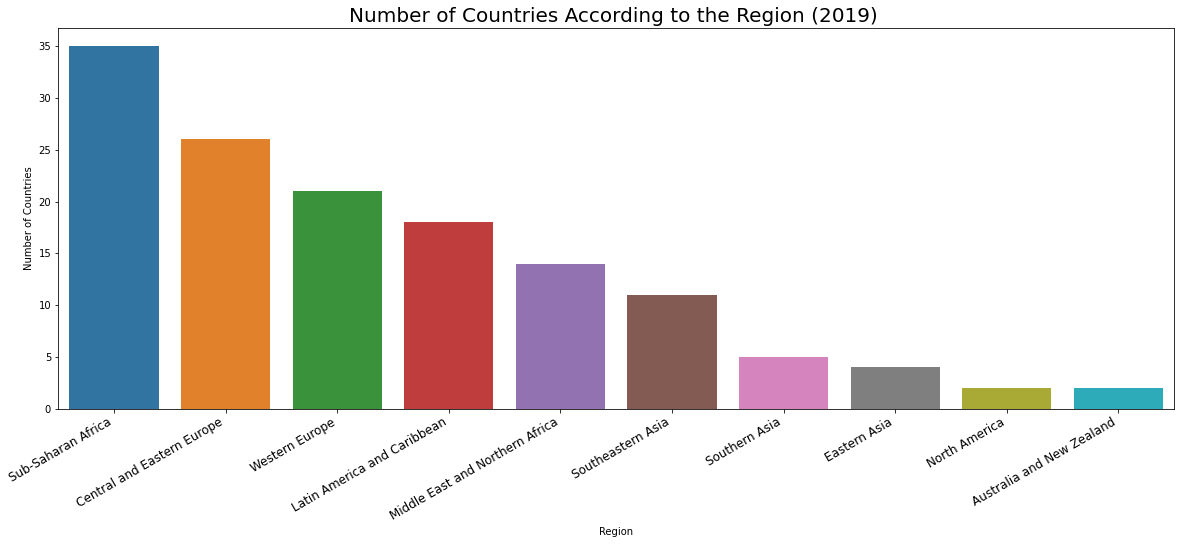

In [8]:
dt2019 = data2019.Region.value_counts()
plt.figure(figsize=(20,7))
sns.barplot(x = dt2019.index, y = dt2019.values)
plt.xlabel('Region')
plt.xticks(rotation = 30,fontweight=50,horizontalalignment='right',fontsize=12)
plt.ylabel('Number of Countries')
plt.title('Number of Countries According to the Region (2019) ', color = 'black', fontsize = 20)
plt.show()

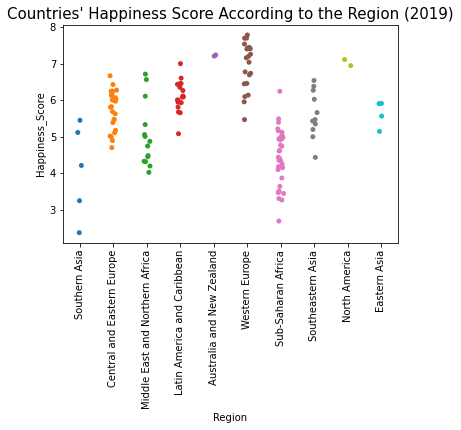

In [9]:
sns.stripplot(x = "Region", y = "Happiness_Score", data = data2019, jitter = True)
plt.xticks(rotation = 90)
plt.title("Countries' Happiness Score According to the Region (2019)", color = 'black', fontsize = 15)
plt.show()

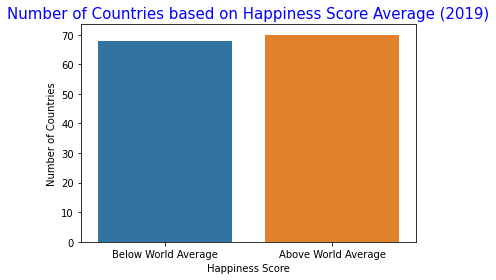

In [10]:
above_mean_HS =['Above World Average' if i >= data2019.mean()['Happiness_Score'] else 'Below World Average' for i in data2019.Happiness_Score]
df1 = pd.DataFrame({'Happiness_Score' : above_mean_HS})
sns.countplot(x = df1.Happiness_Score)
plt.xlabel('Happiness Score')
plt.ylabel('Number of Countries')
plt.title('Number of Countries based on Happiness Score Average (2019)', color = 'blue', fontsize = 15)
plt.show()

In [11]:
trace1 = go.Box(
    y = data2019.Economy,
    name = 'Economic Situations of Countries in 2019',
    marker = dict(
        color = 'rgb(12, 12, 140)',
    )
)
trace2 = go.Box(
    y = data2019.Trust,
    name = 'Government Corruption Index in 2019',
    marker = dict(
        color = 'rgb(12, 128, 128)',
    )
)
data = [trace1, trace2]
iplot(data)

In [12]:
import plotly.figure_factory as ff

dataframe = data2019
dt2019 = dataframe.loc[:,["Economy", "Life_expectancy", "Freedom"]]
dt2019["index"] = np.arange(1, len(dt2019) + 1)

fig = ff.create_scatterplotmatrix(dt2019, diag = 'box', index = 'index', colormap = 'Portland',
                                  colormap_type = 'cat',
                                  height = 700, width = 700)
iplot(fig)

In [13]:
data2019.sort_values(by=['Happiness_Score'], inplace=True, ascending=False)



df2019 = data2019.iloc[:3, :]


trace1 = go.Bar(
                x = df2019.Country,
                y = df2019.Economy,
                name = "Economy",
                marker = dict(color = 'rgba(125, 25, 200, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace2 = go.Bar(
                x = df2019.Country,
                y = df2019.Social_support,
                name = "Social support",
                marker = dict(color = 'rgba(25, 25, 25, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace3 = go.Bar(
                x = df2019.Country,
                y = df2019.Life_expectancy,
                name = "Life expectancy",
                marker = dict(color = 'rgba(190, 200, 100, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace4 = go.Bar(
                x = df2019.Country,
                y = df2019.Trust,
                name = "Trust",
                marker = dict(color = 'rgba(50, 150, 50, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace5 = go.Bar(
                x = df2019.Country,
                y = df2019.Generosity,
                name = "Generosity",
                marker = dict(color = 'rgba(255, 70, 12, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace6 = go.Bar(
                x = df2019.Country,
                y = df2019.Freedom,
                name = "Freedom",
                marker = dict(color = 'rgba(255, 25, 55, 0.8)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
data = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = go.Layout(barmode = 'group', title = 'Top 3 Countries in 2017 According to the Different Parameters')
fig = go.Figure(data = data, layout = layout)
iplot(fig)

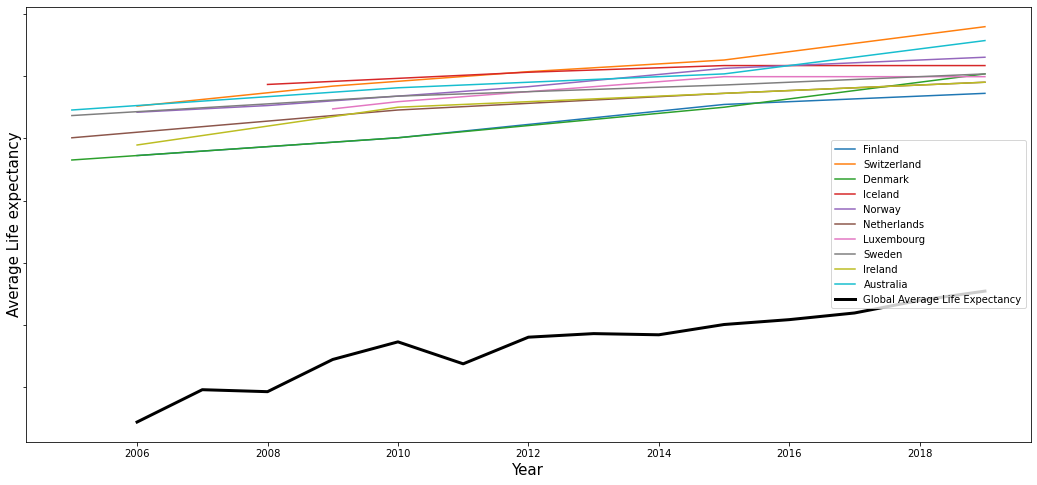

In [14]:
top10countries=data2019.values[0:10,0]
plt.figure(figsize=(18,8))
for country in top10countries:
    plt.plot(df['year'].loc[df['Country']==country],df['Life_expectancy'].loc[df['Country']==country], label=country,linewidth=1.5)
global_mean=df.groupby(['year'])['Life_expectancy'].mean()
#Taking Values from 2006 as 2005 data contains very few countries
plt.plot(global_mean[1:][:],color='black',linewidth=3,label='Global Average Life Expectancy') 
plt.legend(loc=5)
plt.tick_params(
    axis='y',          
    which='both',      
    labelleft=False)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Average Life expectancy',fontsize=15)
plt.show()

In [15]:
fig = px.scatter(data2019, x='Happiness_Score', y='Economy', text='Country')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=1000,
)
fig.show()

<Figure size 1440x1440 with 0 Axes>

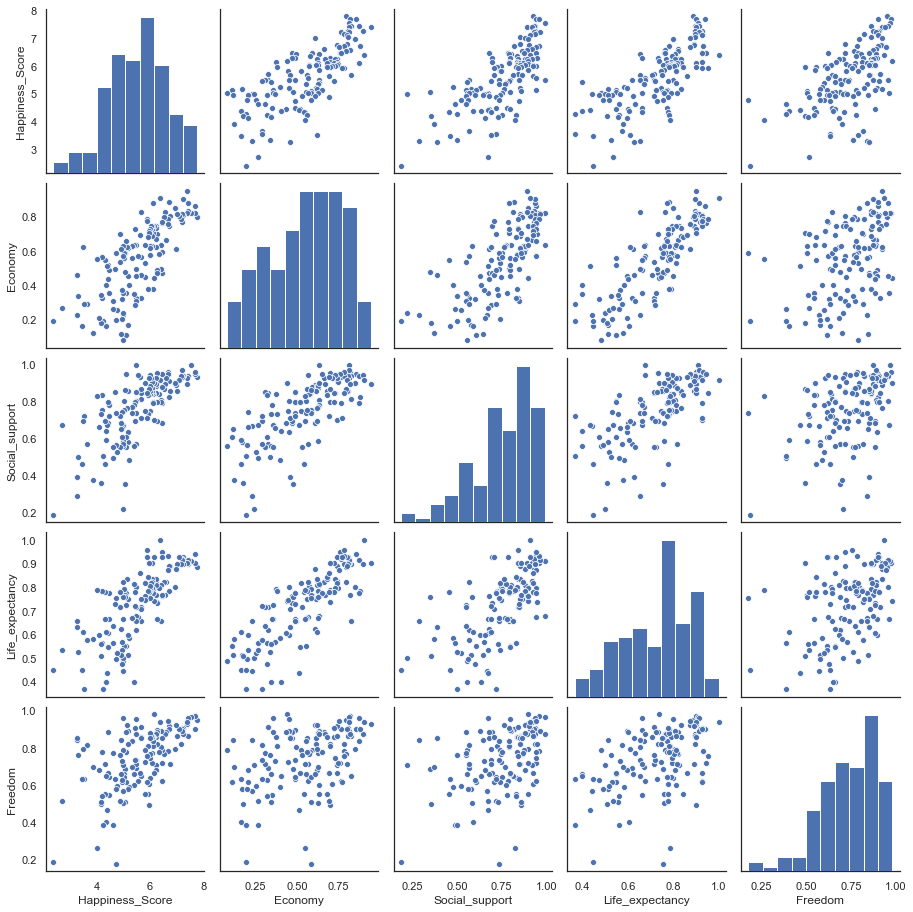

In [16]:
fig = plt.figure(figsize=(20,20))
sns.set(style="white",font_scale=1);
sns.pairplot(data2019[['Happiness_Score','Economy', 'Social_support', 'Life_expectancy', 'Freedom']]);

In [17]:
data = dict(type = 'choropleth', 
           locations = data2019['Country'],
           locationmode = 'country names',
           z = data2019['Happiness_Score'], 
           text = data2019['Country'],
           colorbar = {'title':'Happiness'})
layout = dict(title = 'Global Happiness 2019', 
             geo = dict(showframe = True, 
                       ))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

## FEATURE SELECTION

### Splitting dataset into train and test datasets

In [18]:
featurevector = ['Economy', 'Social_support', 'Life_expectancy',
       'Freedom', 'Positive affect', 'Delivery Quality', 
       'Standard deviation/Mean of ladder by country-year']

target = 'Happiness_Score'

X = df[featurevector].values
y = df[target].values

# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # This is a regression problem and stratify is used to divide the train and test based on labels supplied (which is for classification). Hence you cannot use stratify here

In [19]:
featurevector = ['Economy', 'Social_support', 'Life_expectancy',
       'Freedom', 'Generosity', 'Trust', 'Positive affect', 'Negative affect', 'GINI']

target = 'Happiness_Score'

X = df[featurevector].values
y = df[target].values

# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## PCA

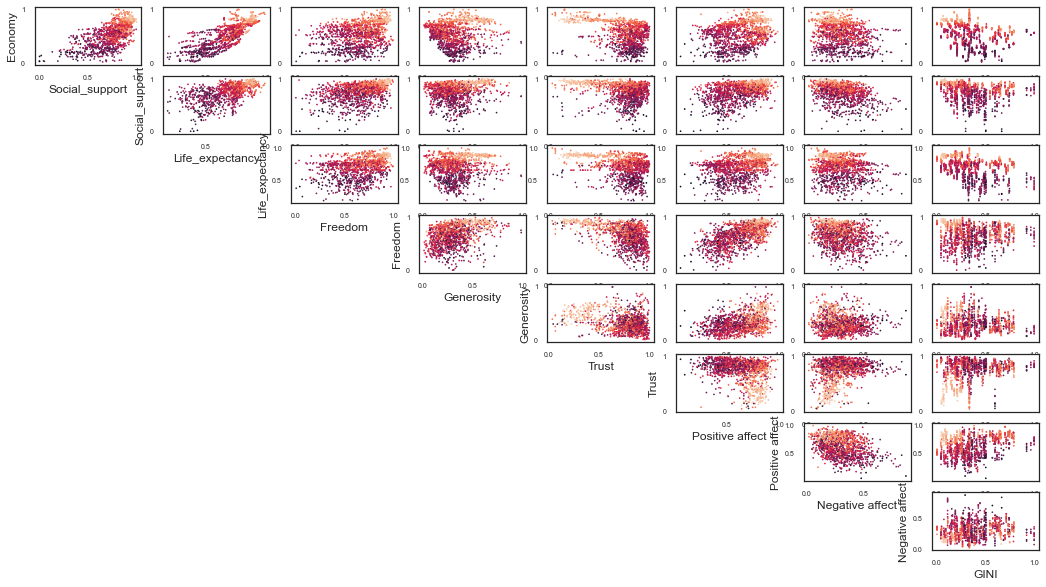

In [20]:
gs = gridspec.GridSpec(8, 8)
plt.figure(figsize=(18,10))
for ny in range(8):
    for nx in range(ny+1, 9):
        plt.subplot(gs[ny, nx-1])
        plt.scatter(X_train[:, nx], X_train[:, ny], c=y_train, s=.5)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7);
        if ny == nx-1:
            plt.xlabel(featurevector[nx])
            plt.ylabel(featurevector[ny])

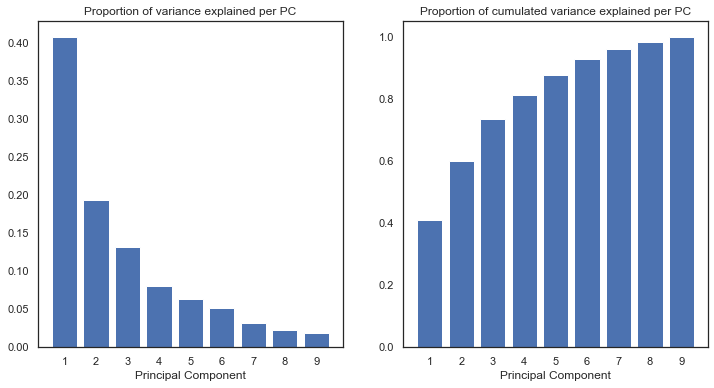

In [21]:
pca = PCA()

# Fit a model to the training data; unsupervised---no labels needed
X_train_PCA = pca.fit_transform(X_train)

# Plot explained variance 
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.bar(range(1, 10), pca.explained_variance_ratio_)
plt.title('Proportion of variance explained per PC')
plt.xlabel('Principal Component')
plt.xticks(range(1, 10));

# Plot cumulated variance explained
plt.subplot(1, 2, 2)
plt.bar(range(1, 10), pca.explained_variance_ratio_.cumsum())
plt.title('Proportion of cumulated variance explained per PC')
plt.xlabel('Principal Component')
plt.xticks(range(1, 10))
plt.show()

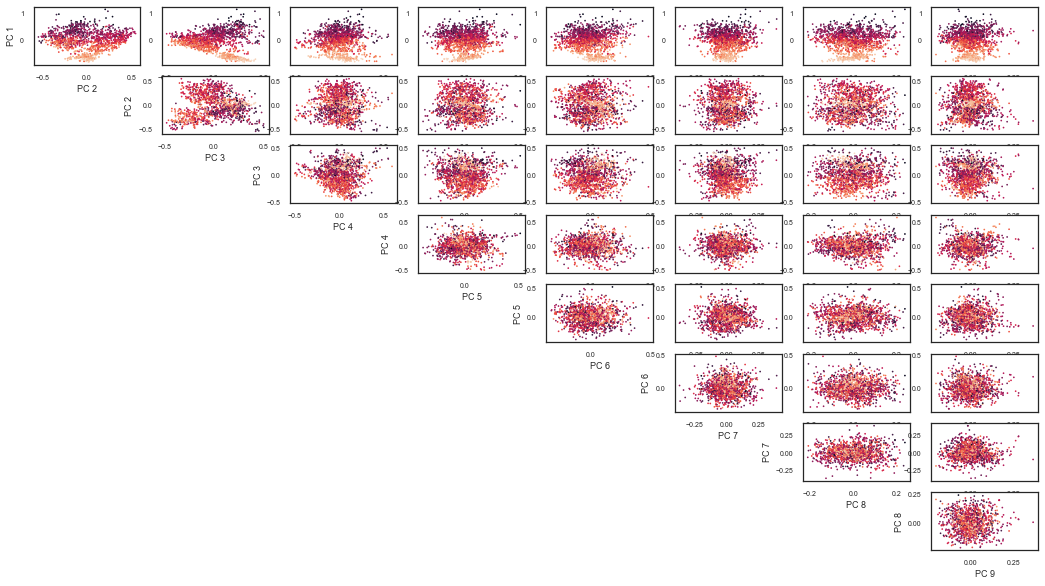

In [22]:
plt.figure(figsize=(18,10))
for ny in range(8):
    for nx in range(ny+1, 9):
        plt.subplot(gs[ny, nx-1])
        plt.scatter(X_train_PCA[:, nx], X_train_PCA[:, ny], c=y_train, s=0.5)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7);
        if ny == nx-1:
            plt.xlabel('PC {}'.format(nx+1), fontsize=9)
            plt.ylabel('PC {}'.format(ny+1), fontsize=9)

### Feature Scaling

In [23]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Using Pearson Correlation

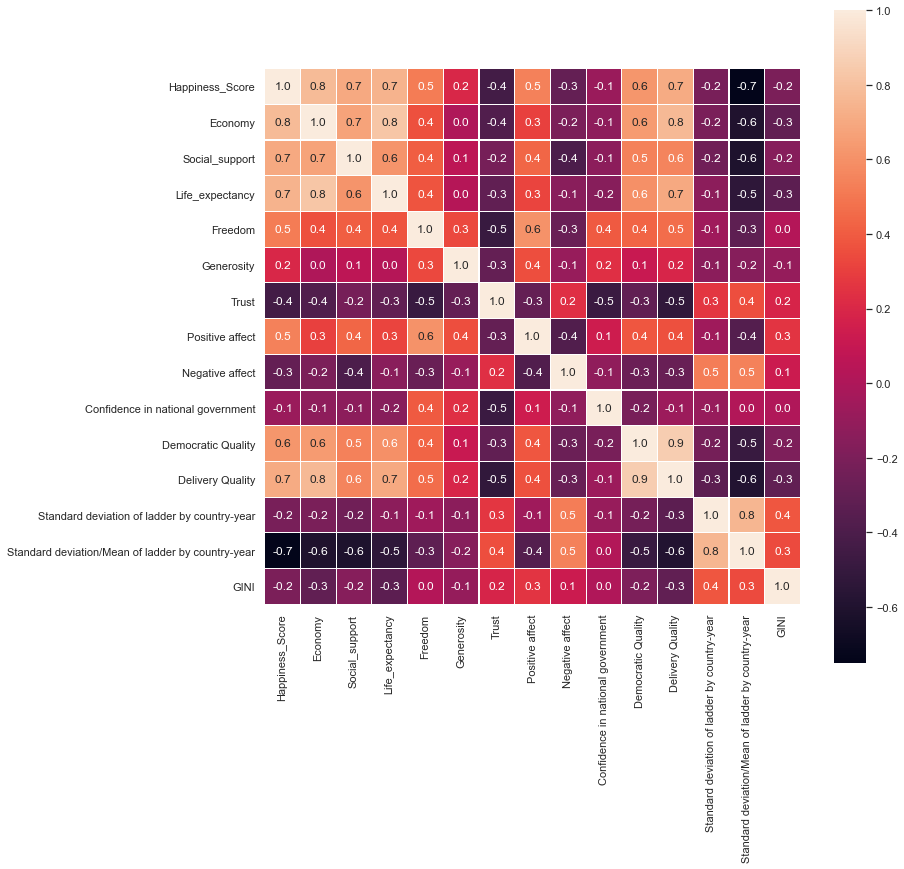

In [24]:
#Using Pearson Correlation
df_correl = df.drop(columns=['year'])
f,ax = plt.subplots(figsize = (12, 12))
sns.heatmap(df_correl.corr(), annot = True, linewidths = 0.1, fmt = '.1f', ax = ax, square = True)

In [25]:
#Correlation with output variable
cor = df.corr()
cor_target = abs(cor["Happiness_Score"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

Happiness_Score                                      1.000000
Economy                                              0.776604
Social_support                                       0.704725
Life_expectancy                                      0.740656
Freedom                                              0.517423
Positive affect                                      0.538099
Democratic Quality                                   0.623848
Delivery Quality                                     0.708385
Standard deviation/Mean of ladder by country-year    0.749721
Name: Happiness_Score, dtype: float64

# Cluster Analysis

In [26]:
n_clusters = 3
KM = KMeans(n_clusters,  
            init='random', 
            n_init=20,     
            max_iter=300,
            tol=1e-04,  
            random_state=0)

sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

groupsKM = KM.fit_predict(X_std)

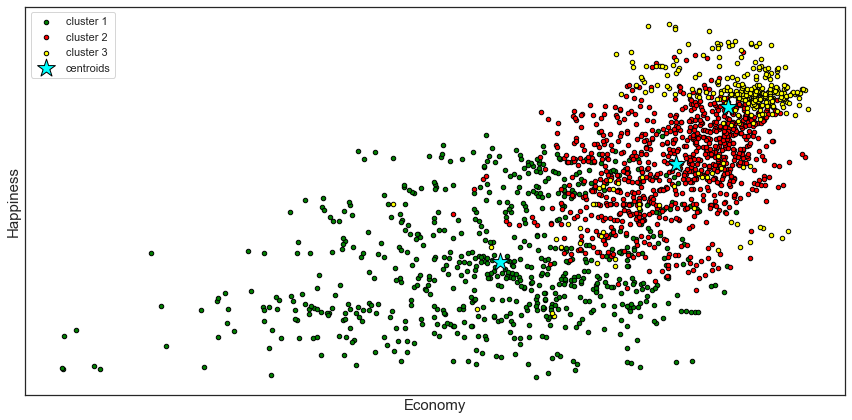

In [27]:
plt_col = ['green', 'red',  'yellow', 'blue','purple', 'pink', 'black', 'magenta', 'orange', 'brown']
plt.figure(figsize=(12,6))
for k in range(n_clusters):
    plt.scatter(X_std[groupsKM == k, 1],
                X_std[groupsKM == k, 0],
                s=20, c=plt_col[k],
                marker='o', edgecolor='black',
                label='cluster {}'.format(k+1))

# Plot cluster centres
plt.scatter(KM.cluster_centers_[:, 1],
            KM.cluster_centers_[:, 0],
            s=350, marker='*',
            c='cyan', edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)
plt.xlabel("Economy", fontsize=15)
plt.ylabel("Happiness", fontsize=15)
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)
plt.tight_layout()
plt.show()

1848


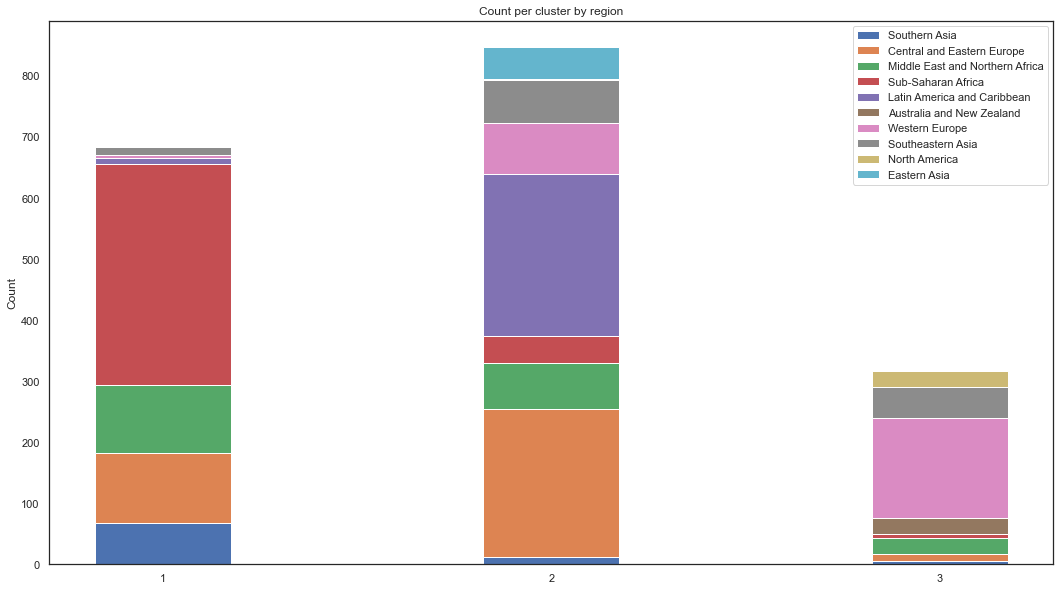

In [28]:
cum_arr = []
for i in df.Region.unique():
    part_arr = []
    for j in range(n_clusters):
        part_arr.append(df[groupsKM == j].loc[df['Region'] == i].shape[0])
    cum_arr.append(part_arr)
print(sum(sum(x) for x in cum_arr))

reg0 = np.array(cum_arr[0])
reg1 = np.array(cum_arr[1])
reg2 = np.array(cum_arr[2])
reg3 = np.array(cum_arr[3])
reg4 = np.array(cum_arr[4])
reg5 = np.array(cum_arr[5])
reg6 = np.array(cum_arr[6])
reg7 = np.array(cum_arr[7])
reg8 = np.array(cum_arr[8])
reg9 = np.array(cum_arr[9])

labels = [str(i) for i in range(1,n_clusters+1)]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(18,10))

ax.bar(labels, reg0, width, label='Southern Asia')
ax.bar(labels, reg1, width, label='Central and Eastern Europe', bottom=reg0)
ax.bar(labels, reg2, width, label='Middle East and Northern Africa', bottom=reg0+reg1)
ax.bar(labels, reg3, width, label='Sub-Saharan Africa', bottom=reg0+reg1+reg2)
ax.bar(labels, reg4, width, label='Latin America and Caribbean', bottom=reg0+reg1+reg2+reg3)
ax.bar(labels, reg5, width, label='Australia and New Zealand', bottom=reg0+reg1+reg2+reg3+reg4)
ax.bar(labels, reg6, width, label='Western Europe', bottom=reg0+reg1+reg2+reg3+reg4+reg5)
ax.bar(labels, reg7, width, label='Southeastern Asia', bottom=reg0+reg1+reg2+reg3+reg4+reg5+reg6)
ax.bar(labels, reg8, width, label='North America', bottom=reg0+reg1+reg2+reg3+reg4+reg5+reg6+reg7)
ax.bar(labels, reg9, width, label='Eastern Asia', bottom=reg0+reg1+reg2+reg3+reg4+reg5+reg6+reg7+reg8)


ax.set_ylabel('Count')
ax.set_title('Count per cluster by region')
ax.legend()

plt.show()

# Data Analysis and Prediction

## Linear Regression 

In [29]:
logR = LinearRegression()
logR.fit(X_train_std,y_train)
y_pred_logR = logR.predict(X_test_std)

Text(0, 0.5, 'Predicted Value')

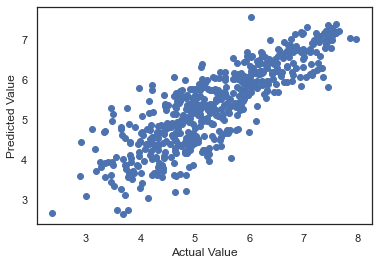

In [30]:
plt.scatter(y_test,y_pred_logR)

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

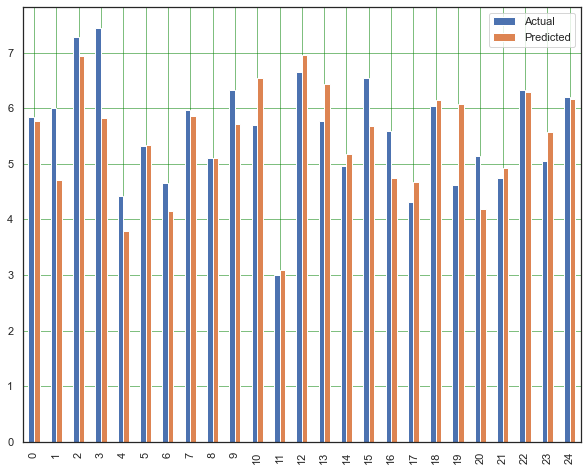

In [31]:
df_logR = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_logR})
df1 = df_logR.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [72]:
performance_metrics.append(list(analysis_score(logR,X_test_std,y_test,y_pred_logR)))

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 45
Test data accuracy: 0.72
Mean squared error: 0.34
Coefficient of determination: 0.72


## SVR

In [33]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train_std, y_train)

#Predict the response for test dataset
y_pred_svr = svr.predict(X_test_std)

In [73]:
performance_metrics.append(list(analysis_score(svr,X_test_std,y_test,y_pred_svr)))

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 17
Test data accuracy: 0.84
Mean squared error: 0.20
Coefficient of determination: 0.84


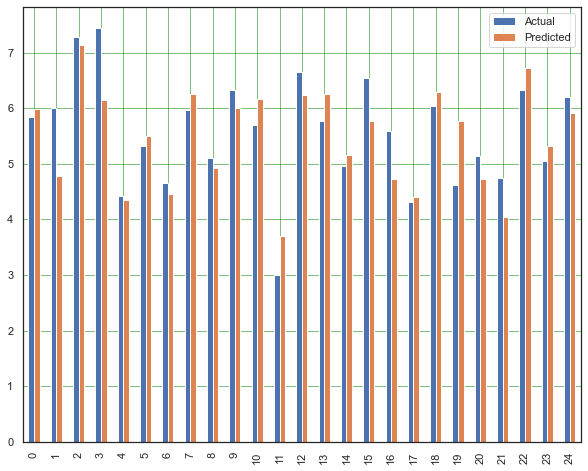

In [35]:
df_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})
df2 = df_svr.head(25)

df2.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## LASSO

In [36]:
lasso = Lasso(alpha=0.1, max_iter = 10000)  
lasso.fit(X_train_std, y_train)
y_pred_train_Lasso  = lasso.predict(X_train_std)
y_pred_test_Lasso  = lasso.predict(X_test_std)
print(lasso.coef_)

[ 0.33994583  0.19591136  0.23514329  0.03725578  0.         -0.0787937
  0.20899632 -0.         -0.        ]


In [74]:
performance_metrics.append(list(analysis_score(lasso,X_test_std,y_test,y_pred_test_Lasso)))

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 65
Test data accuracy: 0.72
Mean squared error: 0.34
Coefficient of determination: 0.72


## Elastic Net

In [38]:
from sklearn.linear_model import ElasticNet

elnet = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter = 100)
elnet.fit(X_train_std, y_train)
y_pred_train_Elnet = elnet.predict(X_train_std)
y_pred_test_Elnet = elnet.predict(X_test_std)

In [75]:
performance_metrics.append(list(analysis_score(elnet,X_test_std,y_test,y_pred_test_Elnet)))

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 410
Test data accuracy: 0.40
Mean squared error: 0.74
Coefficient of determination: 0.40


## Linear Regression using PCA

In [40]:
pca = PCA(n_components=6)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

linRPCA = LinearRegression()
linRPCA = linRPCA.fit(X_train_pca, y_train)
y_pred_pca = linRPCA.predict(X_test_pca)

In [76]:
performance_metrics.append(list(analysis_score(linRPCA,X_test_pca,y_test,y_pred_pca)))

Misclassified samples: 555
Misclassified samples on basis of difference greater than standard deviation: 44
Test data accuracy: 0.72
Mean squared error: 0.34
Coefficient of determination: 0.72


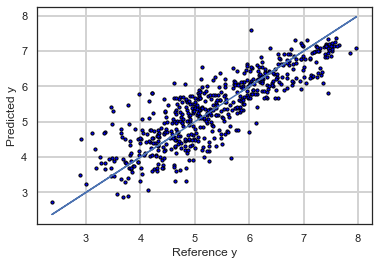

In [42]:
plt.scatter(y_test, y_pred_pca, c='blue', edgecolor='black', s=10)
plt.xlabel('Reference y')
plt.ylabel('Predicted y')
plt.plot(y_test, y_test)
plt.grid(color='LightGrey', linestyle='-', linewidth=2)
plt.show()

### Comparison Between Different algorithms

In [77]:
comparison = pd.DataFrame(data=performance_metrics[1:][:],columns=performance_metrics[0],index=['Linear Regression','SVR','LASSO','Elastic Net','PCA'])


In [82]:
comparison = pd.DataFrame(data=performance_metrics[1:][:],columns=performance_metrics[0],index=['Linear Regression','SVR','LASSO','Elastic Net','PCA'])


trace2 = go.Bar(
                x = comparison.index,
                y = comparison.Accuracy,
                name = performance_metrics[0][1],
                marker = dict(color = 'rgba(255, 0, 0, 1)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace3 = go.Bar(
                x = comparison.index,
                y = comparison[performance_metrics[0][2]],
                name = performance_metrics[0][2],
                marker = dict(color = 'rgba(0, 255, 0, 1)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )
trace4 = go.Bar(
                x = comparison.index,
                y = comparison[performance_metrics[0][3]],
                name = performance_metrics[0][3],
                marker = dict(color = 'rgba(0, 0, 255, 1)',
                             line = dict(color = 'rgb(0,0,0)', width = 1.5))
                )

data = [trace2,trace3,trace4]
layout = go.Layout(barmode = 'group', title = 'Comparison of Performance for different prediction models')
fig = go.Figure(data = data, layout = layout)
iplot(fig)